# For showing off the various Shapes associable with Primitives

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation, RigidTransform

def random_isometry(centered : bool=False) -> RigidTransform:
    """Generate a random rigid transformation"""
    return RigidTransform.from_components(
        translation=np.zeros(3, dtype=float) if centered else np.random.rand(3),
        rotation=Rotation.random(),
    )

## Defining instance of each Shape

### Point Cloud (conformer)

In [2]:
from rdkit.Chem.Draw import IPythonConsole

aspect : float = 3/2
dim : int = 400
IPythonConsole.molSize = (int(aspect*dim), dim)

[22:58:25] UFFTYPER: Unrecognized atom type: *_ (0)
[22:58:25] UFFTYPER: Unrecognized atom type: *_ (8)


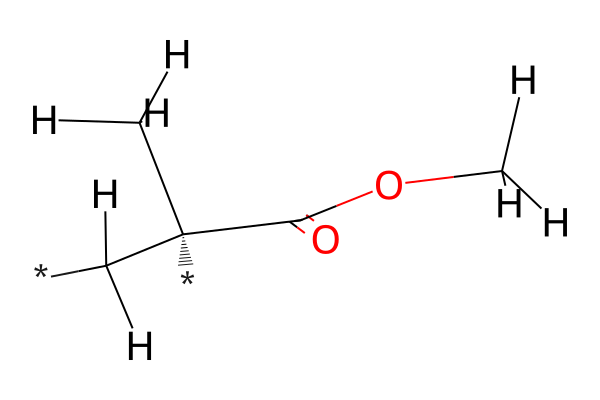

PointCloud(shape=(17, 3))
[True True True True True True True True True True True True True True
 True True True]


In [3]:
from rdkit import Chem
from rdkit.Chem.AllChem import EmbedMolecule

from mupt.geometry.shapes import PointCloud


# define and embed molecule to draw positions from
smi = 'c1c(C(=O)O*)ccc(C(=O)O*)c1' # PET
# smi = '*CC(C(=O)NC(C)C)*' # PNIPAam
smi = '*[C@](C)(C(=O)OC)C*' # PMMA
mol = Chem.MolFromSmiles(smi, sanitize=True)
mol = Chem.AddHs(mol)

# generate conformer and PointCloud instance
err_code = EmbedMolecule(mol)
assert err_code == 0
display(mol)

points = mol.GetConformer(0).GetPositions()
conformer = PointCloud(points)
print(conformer)
print(conformer.contains(points))

### Ellipsoid

[True True True True True True True True True True True False False True
 True True True]
Ellipsoid(radii=array([2., 3., 5.]), center=array([0., 0., 0.]), orientation=Rotation.from_matrix(array([[-0.37549109, -0.31144656, -0.8729304 ],
                            [ 0.92176711, -0.02721725, -0.38678756],
                            [ 0.09670489, -0.94987381,  0.29730103]])))


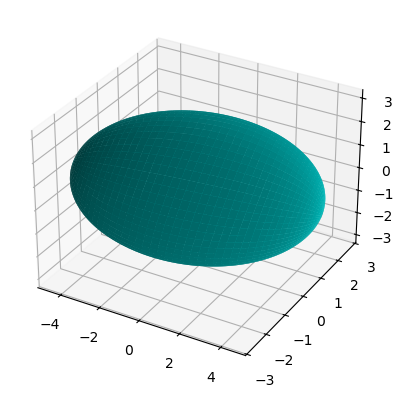

In [5]:
import matplotlib.pyplot as plt
from mupt.geometry.shapes import Ellipsoid


ellipsoid = Ellipsoid.from_axis_lengths_and_transform(
    2, 3, 5,
    transform=random_isometry(centered=True),
)
print(ellipsoid.contains(points))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
_ = ax.plot_surface(*ellipsoid.surface_mesh(100, 100).T, color='c')

print(ellipsoid)

### Cylinder (WIP)

In [6]:
## Cylinder (WIP)
n_r, n_theta = 100, 200
R : float = 1.0
L : float = 8.0

# calculate cylinder wall coordinates
r, theta = np.mgrid[0.0:R:n_r*1j, 0.0:2*np.pi:n_theta*1j]
x_cyl = R * np.cos(theta) # fix radius for walls
y_cyl = R * np.sin(theta) # fix radius for walls
z, _ = np.mgrid[-L/2:L/2:n_r*1j, 0.0:2*np.pi:n_theta*1j]

# calculate face coordinates
x_face = r * np.cos(theta) # vary radius and fix Z for caps
y_face = r * np.sin(theta) # vary radius and fix Z for caps
z_face1 = np.full((n_r, n_theta), fill_value=-L/2)
z_face2 = np.full((n_r, n_theta), fill_value=L/2)

# stack XYZ coordinates together
cyl_pos_ref   = np.dstack([x_cyl, y_cyl, z])
face1_pos_ref = np.dstack([x_face, y_face, z_face1])
face2_pos_ref = np.dstack([x_face, y_face, z_face2])

# apply transform to position in space
transform = random_isometry(centered=False)
cyl_pos = transform.apply(cyl_pos_ref.reshape(-1, 3)).reshape(n_r, n_theta, 3)
face1_pos = transform.apply(face1_pos_ref.reshape(-1, 3)).reshape(n_r, n_theta, 3)
face2_pos = transform.apply(face2_pos_ref.reshape(-1, 3)).reshape(n_r, n_theta, 3)


## Export Shapes as animated GIFs

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


shapes_dir = Path('visuals/shapes')
shapes_dir.mkdir(parents=True, exist_ok=True)

n_frames : int = 100
loop_time_sec : float = 5
interval = int(loop_time_sec*1000/n_frames) # convert to milliseconds

ax_min, ax_max = -4, 4
    
def justify_3d_coordinate_axes(ax : plt.Axes, ax_min : float, ax_max : float):
    for char in 'xyz':
        getattr(ax, f'set_{char}label')(char)
        getattr(ax, f'set_{char}lim')(ax_min, ax_max)
        
def init_ellipsoid():
    ax.plot_surface(*ellipsoid.surface_mesh(100, 100).T, color='b')
    
def init_point_cloud():
    ax.scatter(*conformer.positions.T, color='b')
    
def init_cylinder():
    ax.plot_surface(*cyl_pos.T  , color='b')
    ax.plot_surface(*face1_pos.T, color='c')
    ax.plot_surface(*face2_pos.T, color='c')
    
shape_plotters = {
    'ellipsoid' : init_ellipsoid,
    'point_cloud' : init_point_cloud,
    'cylinder' : init_cylinder,
}
    
def animate(i):
    ax.view_init(azim=(i/n_frames)*360)
    
for shape_name, plotter in shape_plotters.items():
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d', autoscale_on=False)
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d', 'autoscale_on': False})
    # fig.suptitle(shape_name)
    ax.set_title(shape_name)
    justify_3d_coordinate_axes(ax, ax_min, ax_max)
    fig.set_tight_layout(True)
        
    anim = FuncAnimation(fig, animate, init_func=plotter, frames=n_frames, interval=interval, blit=False)
    anim.save(shapes_dir / f'{shape_name}.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
